# EDA of the data
* Performing an EDA of the data to discover preliminary patterns and problems which we will use in our preprocessing of the data
# Importing required libraries

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Setting up display options for pandas

In [80]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Loading the data
* Try to load from pickle file as it is quicker to access
* If this fails, load the original CSV and save it to a pickle file
* <b>No point in doing anything with weather data as we only have 1 years worth of values so it is impossible to leverage with our chosen RNN/CNN based models to predict the next years worth of energy readings</b>
    * <b>Unless we leveraged them to produce multivariate predictions and also predicting the weathers values in order to use those as input for subsequent days: but this will likely result in worse performing energy predictions</b>
* Hence we are only looking into addInfo and consumption

In [81]:
#try to load pickle file as it is quicker
try:
    print("Loading consumption via pickle")
    df_energy = pd.read_pickle("../Data/Original_Data/consumption.pkl")
# if the file was not found then load the csv then save it to pickle for future loads
except:
    print("Loading consumption via csv")
    df_energy = pd.read_csv("../Data/Original_Data/consumption.csv")
    df_energy.to_pickle("../Data/Original_Data/consumption.pkl")

    #try to load pickle file as it is quicker
try:
    print("Loading addInfo via pickle")
    df_info = pd.read_pickle("../Data/Original_Data/addInfo.pkl")
# if the file was not found then load the csv then save it to pickle for future loads
except:
    print("Loading addInfo via csv")
    df_info = pd.read_csv("../Data/Original_Data/addInfo.csv")
    df_info.to_pickle("../Data/Original_Data/addInfo.pkl")

Loading consumption via pickle
Loading addInfo via pickle


# Inspecting df_energy and df_info

In [82]:
# inspecting the values of the dataframe
df_energy

,meter_id,2017-01-01 00:00:00,2017-01-01 00:30:00,2017-01-01 01:00:00,2017-01-01 01:30:00,2017-01-01 02:00:00,2017-01-01 02:30:00,2017-01-01 03:00:00,2017-01-01 03:30:00,2017-01-01 04:00:00,2017-01-01 04:30:00,2017-01-01 05:00:00,2017-01-01 05:30:00,2017-01-01 06:00:00,2017-01-01 06:30:00,2017-01-01 07:00:00,2017-01-01 07:30:00,2017-01-01 08:00:00,2017-01-01 08:30:00,2017-01-01 09:00:00,2017-01-01 09:30:00,2017-01-01 10:00:00,2017-01-01 10:30:00,2017-01-01 11:00:00,2017-01-01 11:30:00,2017-01-01 12:00:00,2017-01-01 12:30:00,2017-01-01 13:00:00,2017-01-01 13:30:00,2017-01-01 14:00:00,2017-01-01 14:30:00,2017-01-01 15:00:00,2017-01-01 15:30:00,2017-01-01 16:00:00,2017-01-01 16:30:00,2017-01-01 17:00:00,2017-01-01 17:30:00,2017-01-01 18:00:00,2017-01-01 18:30:00,2017-01-01 19:00:00,2017-01-01 19:30:00,2017-01-01 20:00:00,2017-01-01 20:30:00,2017-01-01 21:00:00,2017-01-01 21:30:00,2017-01-01 22:00:00,2017-01-01 22:30:00,2017-01-01 23:00:00,2017-01-01 23:30:00,2017-01-02 00:00:00,2017-01-02 00:30:00,2017-01-02 01:00:00,2017-01-02 01:30:00,2017-01-02 02:00:00,2017-01-02 02:30:00,2017-01-02 03:00:00,2017-01-02 03:30:00,2017-01-02 04:00:00,2017-01-02 04:30:00,2017-01-02 05:00:00,2017-01-02 05:30:00,2017-01-02 06:00:00,2017-01-02 06:30:00,2017-01-02 07:00:00,2017-01-02 07:30:00,2017-01-02 08:00:00,2017-01-02 08:30:00,2017-01-02 09:00:00,2017-01-02 09:30:00,2017-01-02 10:00:00,2017-01-02 10:30:00,2017-01-02 11:00:00,2017-01-02 11:30:00,2017-01-02 12:00:00,2017-01-02 12:30:00,2017-01-02 13:00:00,2017-01-02 13:30:00,2017-01-02 14:00:00,2017-01-02 14:30:00,2017-01-02 15:00:00,2017-01-02 15:30:00,2017-01-02 16:00:00,2017-01-02 16:30:00,2017-01-02 17:00:00,2017-01-02 17:30:00,2017-01-02 18:00:00,2017-01-02 18:30:00,2017-01-02 19:00:00,2017-01-02 19:30:00,2017-01-02 20:00:00,2017-01-02 20:30:00,2017-01-02 21:00:00,2017-01-02 21:30:00,2017-01-02 22:00:00,2017-01-02 22:30:00,2017-01-02 23:00:00,2017-01-02 23:30:00,2017-01-03 00:00:00,2017-01-03 00:30:00,2017-01-03 01:00:00,2017-01-03 01:30:00,2017-01-03 02:00:00,2017-01-03 02:30:00,2017-01-03 03:00:00,2017-01-03 03:30:00,2017-01-03 04:00:00,2017-01-03 04:30:00,2017-01-03 05:00:00,2017-01-03 05:30:00,2017-01-03 06:00:00,2017-01-03 06:30:00,2017-01-03 07:00:00,2017-01-03 07:30:00,2017-01-03 08:00:00,2017-01-03 08:30:00,2017-01-03 09:00:00,2017-01-03 09:30:00,2017-01-03 10:00:00,2017-01-03 10:30:00,2017-01-03 11:00:00,2017-01-03 11:30:00,2017-01-03 12:00:00,2017-01-03 12:30:00,2017-01-03 13:00:00,2017-01-03 13:30:00,2017-01-03 14:00:00,2017-01-03 14:30:00,2017-01-03 15:00:00,2017-01-03 15:30:00,2017-01-03 16:00:00,2017-01-03 16:30:00,2017-01-03 17:00:00,2017-01-03 17:30:00,2017-01-03 18:00:00,2017-01-03 18:30:00,2017-01-03 19:00:00,2017-01-03 19:30:00,2017-01-03 20:00:00,2017-01-03 20:30:00,2017-01-03 21:00:00,2017-01-03 21:30:00,2017-01-03 22:00:00,2017-01-03 22:30:00,2017-01-03 23:00:00,2017-01-03 23:30:00,2017-01-04 00:00:00,2017-01-04 00:30:00,2017-01-04 01:00:00,2017-01-04 01:30:00,2017-01-04 02:00:00,2017-01-04 02:30:00,2017-01-04 03:00:00,2017-01-04 03:30:00,2017-01-04 04:00:00,2017-01-04 04:30:00,2017-01-04 05:00:00,2017-01-04 05:30:00,2017-01-04 06:00:00,2017-01-04 06:30:00,2017-01-04 07:00:00,2017-01-04 07:30:00,2017-01-04 08:00:00,2017-01-04 08:30:00,2017-01-04 09:00:00,2017-01-04 09:30:00,2017-01-04 10:00:00,2017-01-04 10:30:00,2017-01-04 11:00:00,2017-01-04 11:30:00,2017-01-04 12:00:00,2017-01-04 12:30:00,2017-01-04 13:00:00,2017-01-04 13:30:00,2017-01-04 14:00:00,2017-01-04 14:30:00,2017-01-04 15:00:00,2017-01-04 15:30:00,2017-01-04 16:00:00,2017-01-04 16:30:00,2017-01-04 17:00:00,2017-01-04 17:30:00,2017-01-04 18:00:00,2017-01-04 18:30:00,2017-01-04 19:00:00,2017-01-04 19:30:00,2017-01-04 20:00:00,2017-01-04 20:30:00,2017-01-04 21:00:00,2017-01-04 21:30:00,2017-01-04 22:00:00,2017-01-04 22:30:00,2017-01-04 23:00:00,2017-01-04 23:30:00,2017-01-05 00:00:00,2017-01-05 00:30:00,2017-01-05 01:00:00,2017-01-05 01:30:00,2017-01-05 02:00:00,2017-01-05 02:30:00,2017-01-05 03:00:00,2017-01-05

In [83]:
# inspecting the shape of the dataframe
df_energy.shape

(3248, 17521)

In [84]:
# inspecting the values of the dataframe
df_info

,meter_id,dwelling_type,num_occupants,num_bedrooms,heating_fuel,hot_water_fuel,boiler_age,loft_insulation,wall_insulation,heating_temperature,efficient_lighting_percentage,dishwasher,freezer,fridge_freezer,refrigerator,tumble_dryer,washing_machine,game_console,laptop,pc,router,set_top_box,tablet,tv
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,terraced_house,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,semi_detached_house,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,0xb9c600842cb2d195d461d675f2758ddbf5bb45bb,terraced_house,2.0,2.0,gas,gas,old,y,n,18_to_20,75_to_100,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0
2139,0x429e76a41f3141d9e62c4975e6b5df303cb45e64,bungalow,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2140,0x65fbd9ba598e703d742a32058ea2b323fe4c1fca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2141,0x101f2dc409b3b95d2bb08ebe5d282f54317e3f8c,bungalow,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# inspecting the shape of the dataframe
df_info.shape

(2143, 24)

* Can see that df_info only has entries for 2140 of the 3248 possible rows
* Must add the missing rows filled with NaN

# Adding the missing rows to addInfo

In [86]:
# first making both dataframes alphabetical in order of meter_id for ease of comparison
df_info.sort_values('meter_id')

,meter_id,dwelling_type,num_occupants,num_bedrooms,heating_fuel,hot_water_fuel,boiler_age,loft_insulation,wall_insulation,heating_temperature,efficient_lighting_percentage,dishwasher,freezer,fridge_freezer,refrigerator,tumble_dryer,washing_machine,game_console,laptop,pc,router,set_top_box,tablet,tv
750,0x000f697092696c27b0bb489ea4c11280ef72ab82,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,0x001d6227832325ab6167b82d6d7175d254f57c3a,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1643,0x005958406351bb29580475df698b5f1070096397,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
694,0x00735e1aa83d97d9209cce47d8777b4ff3cc0554,terraced_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2056,0x0079fa6c2cbd3de97c8aa6073ff365b41ee087ab,terraced_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1463,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1685,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
441,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
df_energy.sort_values('meter_id')

,meter_id,2017-01-01 00:00:00,2017-01-01 00:30:00,2017-01-01 01:00:00,2017-01-01 01:30:00,2017-01-01 02:00:00,2017-01-01 02:30:00,2017-01-01 03:00:00,2017-01-01 03:30:00,2017-01-01 04:00:00,2017-01-01 04:30:00,2017-01-01 05:00:00,2017-01-01 05:30:00,2017-01-01 06:00:00,2017-01-01 06:30:00,2017-01-01 07:00:00,2017-01-01 07:30:00,2017-01-01 08:00:00,2017-01-01 08:30:00,2017-01-01 09:00:00,2017-01-01 09:30:00,2017-01-01 10:00:00,2017-01-01 10:30:00,2017-01-01 11:00:00,2017-01-01 11:30:00,2017-01-01 12:00:00,2017-01-01 12:30:00,2017-01-01 13:00:00,2017-01-01 13:30:00,2017-01-01 14:00:00,2017-01-01 14:30:00,2017-01-01 15:00:00,2017-01-01 15:30:00,2017-01-01 16:00:00,2017-01-01 16:30:00,2017-01-01 17:00:00,2017-01-01 17:30:00,2017-01-01 18:00:00,2017-01-01 18:30:00,2017-01-01 19:00:00,2017-01-01 19:30:00,2017-01-01 20:00:00,2017-01-01 20:30:00,2017-01-01 21:00:00,2017-01-01 21:30:00,2017-01-01 22:00:00,2017-01-01 22:30:00,2017-01-01 23:00:00,2017-01-01 23:30:00,2017-01-02 00:00:00,2017-01-02 00:30:00,2017-01-02 01:00:00,2017-01-02 01:30:00,2017-01-02 02:00:00,2017-01-02 02:30:00,2017-01-02 03:00:00,2017-01-02 03:30:00,2017-01-02 04:00:00,2017-01-02 04:30:00,2017-01-02 05:00:00,2017-01-02 05:30:00,2017-01-02 06:00:00,2017-01-02 06:30:00,2017-01-02 07:00:00,2017-01-02 07:30:00,2017-01-02 08:00:00,2017-01-02 08:30:00,2017-01-02 09:00:00,2017-01-02 09:30:00,2017-01-02 10:00:00,2017-01-02 10:30:00,2017-01-02 11:00:00,2017-01-02 11:30:00,2017-01-02 12:00:00,2017-01-02 12:30:00,2017-01-02 13:00:00,2017-01-02 13:30:00,2017-01-02 14:00:00,2017-01-02 14:30:00,2017-01-02 15:00:00,2017-01-02 15:30:00,2017-01-02 16:00:00,2017-01-02 16:30:00,2017-01-02 17:00:00,2017-01-02 17:30:00,2017-01-02 18:00:00,2017-01-02 18:30:00,2017-01-02 19:00:00,2017-01-02 19:30:00,2017-01-02 20:00:00,2017-01-02 20:30:00,2017-01-02 21:00:00,2017-01-02 21:30:00,2017-01-02 22:00:00,2017-01-02 22:30:00,2017-01-02 23:00:00,2017-01-02 23:30:00,2017-01-03 00:00:00,2017-01-03 00:30:00,2017-01-03 01:00:00,2017-01-03 01:30:00,2017-01-03 02:00:00,2017-01-03 02:30:00,2017-01-03 03:00:00,2017-01-03 03:30:00,2017-01-03 04:00:00,2017-01-03 04:30:00,2017-01-03 05:00:00,2017-01-03 05:30:00,2017-01-03 06:00:00,2017-01-03 06:30:00,2017-01-03 07:00:00,2017-01-03 07:30:00,2017-01-03 08:00:00,2017-01-03 08:30:00,2017-01-03 09:00:00,2017-01-03 09:30:00,2017-01-03 10:00:00,2017-01-03 10:30:00,2017-01-03 11:00:00,2017-01-03 11:30:00,2017-01-03 12:00:00,2017-01-03 12:30:00,2017-01-03 13:00:00,2017-01-03 13:30:00,2017-01-03 14:00:00,2017-01-03 14:30:00,2017-01-03 15:00:00,2017-01-03 15:30:00,2017-01-03 16:00:00,2017-01-03 16:30:00,2017-01-03 17:00:00,2017-01-03 17:30:00,2017-01-03 18:00:00,2017-01-03 18:30:00,2017-01-03 19:00:00,2017-01-03 19:30:00,2017-01-03 20:00:00,2017-01-03 20:30:00,2017-01-03 21:00:00,2017-01-03 21:30:00,2017-01-03 22:00:00,2017-01-03 22:30:00,2017-01-03 23:00:00,2017-01-03 23:30:00,2017-01-04 00:00:00,2017-01-04 00:30:00,2017-01-04 01:00:00,2017-01-04 01:30:00,2017-01-04 02:00:00,2017-01-04 02:30:00,2017-01-04 03:00:00,2017-01-04 03:30:00,2017-01-04 04:00:00,2017-01-04 04:30:00,2017-01-04 05:00:00,2017-01-04 05:30:00,2017-01-04 06:00:00,2017-01-04 06:30:00,2017-01-04 07:00:00,2017-01-04 07:30:00,2017-01-04 08:00:00,2017-01-04 08:30:00,2017-01-04 09:00:00,2017-01-04 09:30:00,2017-01-04 10:00:00,2017-01-04 10:30:00,2017-01-04 11:00:00,2017-01-04 11:30:00,2017-01-04 12:00:00,2017-01-04 12:30:00,2017-01-04 13:00:00,2017-01-04 13:30:00,2017-01-04 14:00:00,2017-01-04 14:30:00,2017-01-04 15:00:00,2017-01-04 15:30:00,2017-01-04 16:00:00,2017-01-04 16:30:00,2017-01-04 17:00:00,2017-01-04 17:30:00,2017-01-04 18:00:00,2017-01-04 18:30:00,2017-01-04 19:00:00,2017-01-04 19:30:00,2017-01-04 20:00:00,2017-01-04 20:30:00,2017-01-04 21:00:00,2017-01-04 21:30:00,2017-01-04 22:00:00,2017-01-04 22:30:00,2017-01-04 23:00:00,2017-01-04 23:30:00,2017-01-05 00:00:00,2017-01-05 00:30:00,2017-01-05 01:00:00,2017-01-05 01:30:00,2017-01-05 02:00:00,2017-01-05 02:30:00,2017-01-05 03:00:00,2017-01-05

In [88]:
#adding the missing meter rows to df_info
df_info_all_meters = pd.merge(df_info, df_energy["meter_id"], on="meter_id",how="outer")

In [89]:
#checking the values are correct now
df_info_all_meters.sort_values('meter_id')

,meter_id,dwelling_type,num_occupants,num_bedrooms,heating_fuel,hot_water_fuel,boiler_age,loft_insulation,wall_insulation,heating_temperature,efficient_lighting_percentage,dishwasher,freezer,fridge_freezer,refrigerator,tumble_dryer,washing_machine,game_console,laptop,pc,router,set_top_box,tablet,tv
2532,0x0001f1c389823f953b2eaee0a61c33539744da0c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
750,0x000f697092696c27b0bb489ea4c11280ef72ab82,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2468,0x0019979ee12c59accd24d1c83291528ced1bb734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,0x001d6227832325ab6167b82d6d7175d254f57c3a,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1643,0x005958406351bb29580475df698b5f1070096397,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1922,0xffb4c5014834a46d09d0092e748c1ef5acd8733f,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1463,0xffbdc1d9209f45668fb0be65b6d50cb999890ccb,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1685,0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5,detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
441,0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
#checking the shape is correct now
df_info_all_meters.shape

(3248, 24)

As can be seen we have now added the missing rows to df_info

# EDA on AddInfo

## Exploring datatypes and unique values

In [91]:
# inspecting the types of each column
df_info_all_meters.dtypes

meter_id                          object
dwelling_type                     object
num_occupants                    float64
num_bedrooms                     float64
heating_fuel                      object
hot_water_fuel                    object
boiler_age                        object
loft_insulation                   object
wall_insulation                   object
heating_temperature               object
efficient_lighting_percentage     object
dishwasher                       float64
freezer                          float64
fridge_freezer                   float64
refrigerator                     float64
tumble_dryer                     float64
washing_machine                  float64
game_console                     float64
laptop                           float64
pc                               float64
router                           float64
set_top_box                      float64
tablet                           float64
tv                               float64
dtype: object

In [92]:
#looking at the unique values for each column
for column in df_info_all_meters.drop(["meter_id"],axis=1).columns:
    print(column+" unique value count: "+str(df_info_all_meters[column].nunique()))
    print(df_info_all_meters[column].unique())
    print()

dwelling_type unique value count: 5
['semi_detached_house' 'terraced_house' 'detached_house' nan 'bungalow'
 'flat']

num_occupants unique value count: 4
[nan  2.  4.  3.  1.]

num_bedrooms unique value count: 5
[ 3.  2. nan  4.  5.  1.]

heating_fuel unique value count: 4
[nan 'gas' 'elec' 'other' 'lpg_oil']

hot_water_fuel unique value count: 3
[nan 'gas' 'elec' 'other']

boiler_age unique value count: 2
[nan 'new' 'old']

loft_insulation unique value count: 2
[nan 'y' 'n']

wall_insulation unique value count: 5
[nan 'y_cavity' 'n' 'y_internal' 'not_sure' 'y_external']

heating_temperature unique value count: 4
[nan '18_to_20' 'above_20' 'below_18' 'not_sure']

efficient_lighting_percentage unique value count: 4
[nan '0_to_25' '25_to_50' '50_to_75' '75_to_100']

dishwasher unique value count: 3
[nan  1.  0.  2.]

freezer unique value count: 3
[nan  2.  1.  0.]

fridge_freezer unique value count: 3
[nan  2.  0.  1.]

refrigerator unique value count: 3
[nan  2.  1.  0.]

tumble_dryer u

* We now know:
    1. The columns that contain categorical values vs the columns that contain real numbers
    2. The unique values for each column
    
## Exploring missing values
### Visualising as histogram

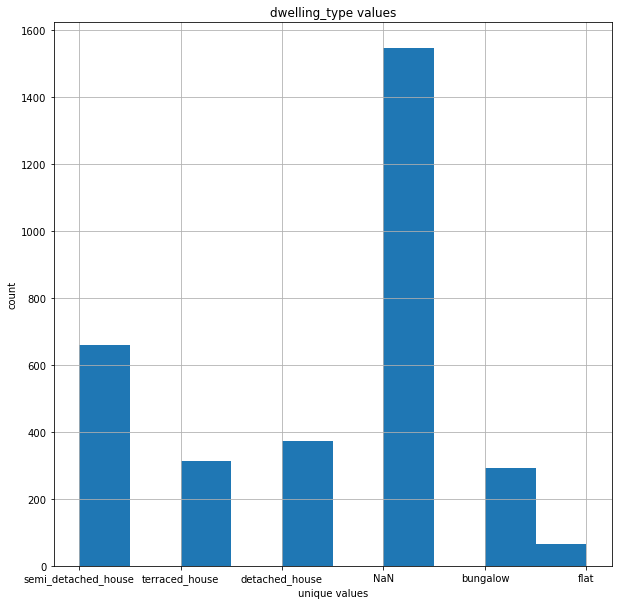

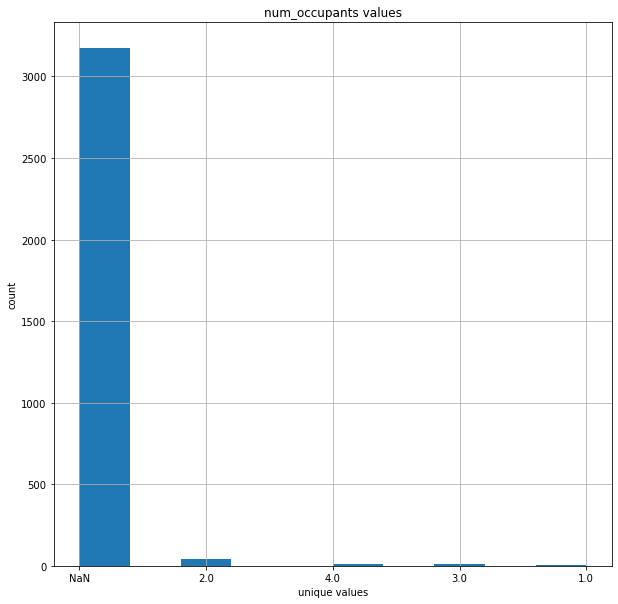

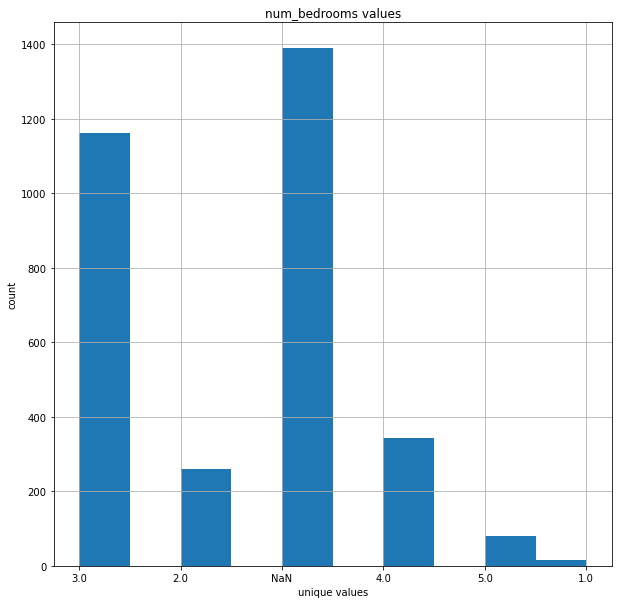

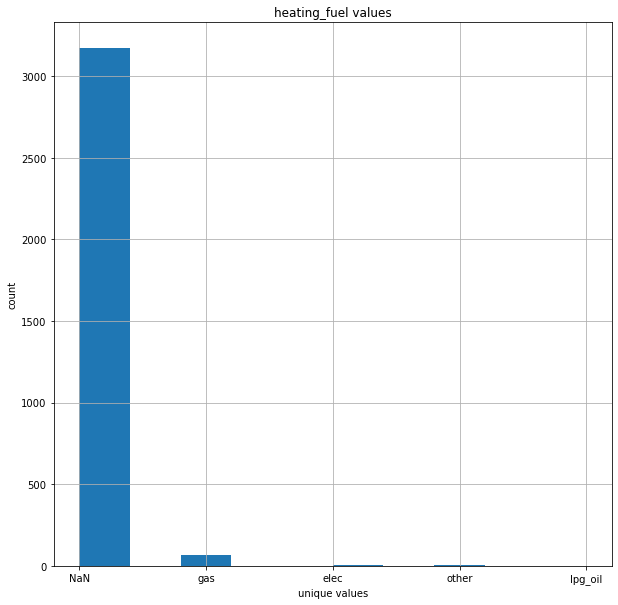

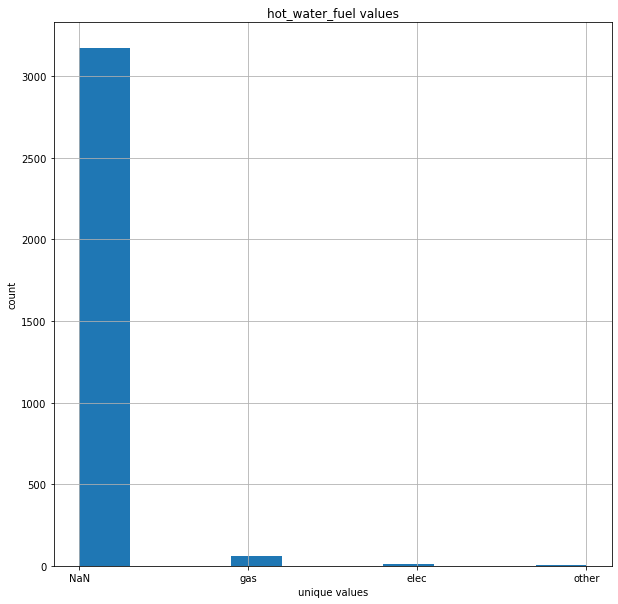

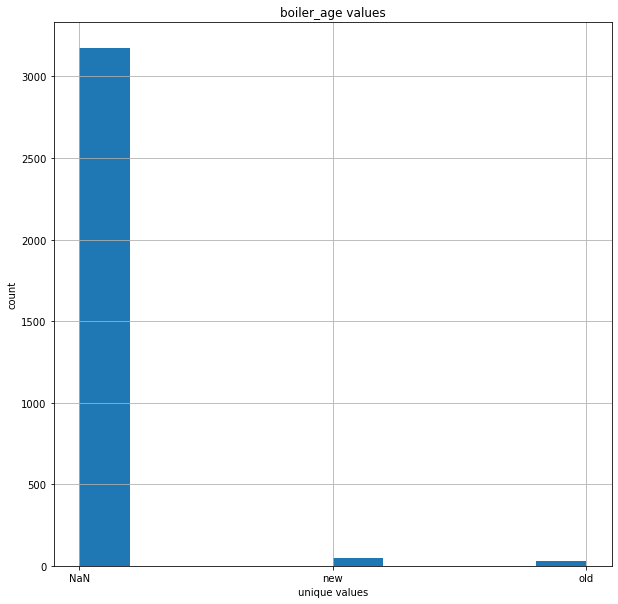

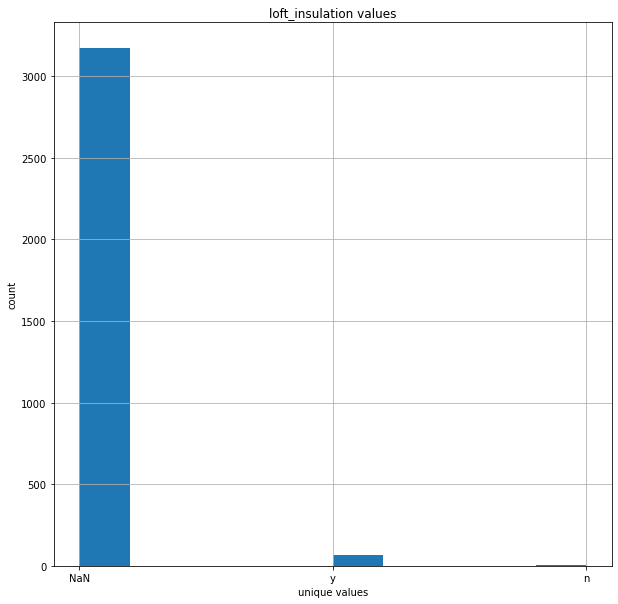

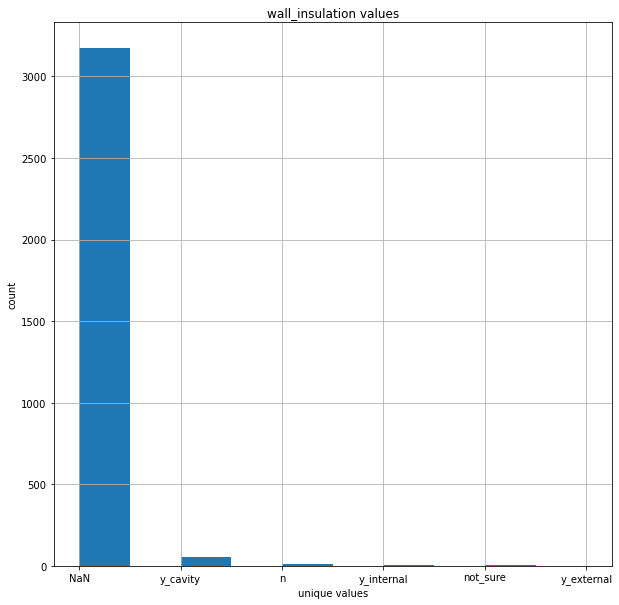

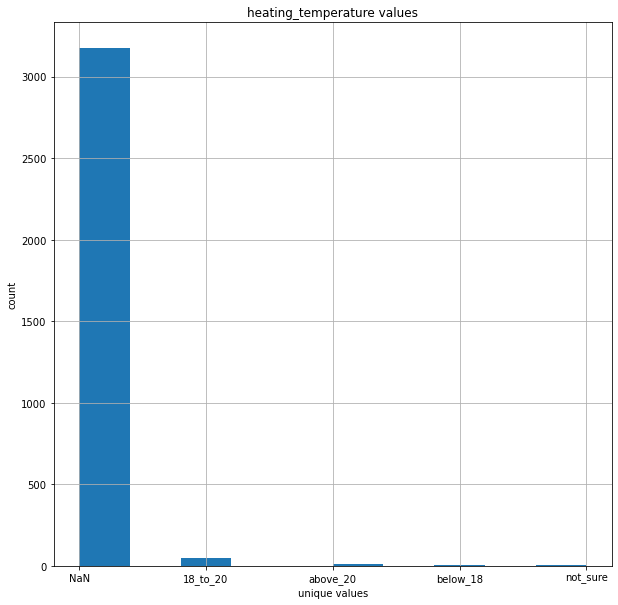

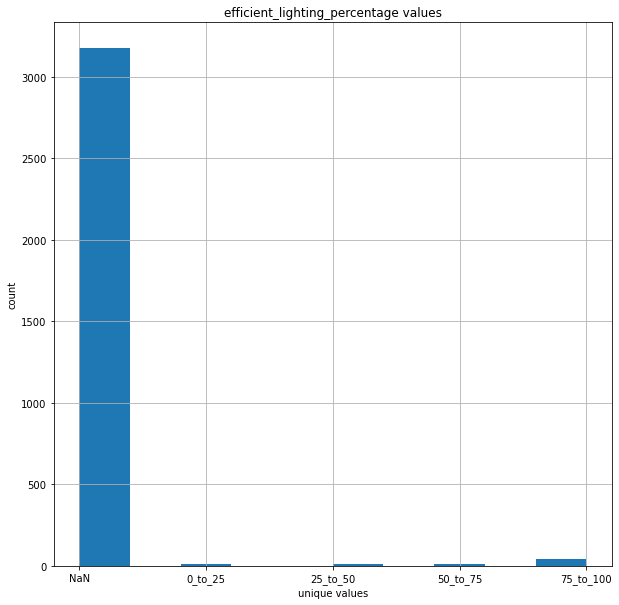

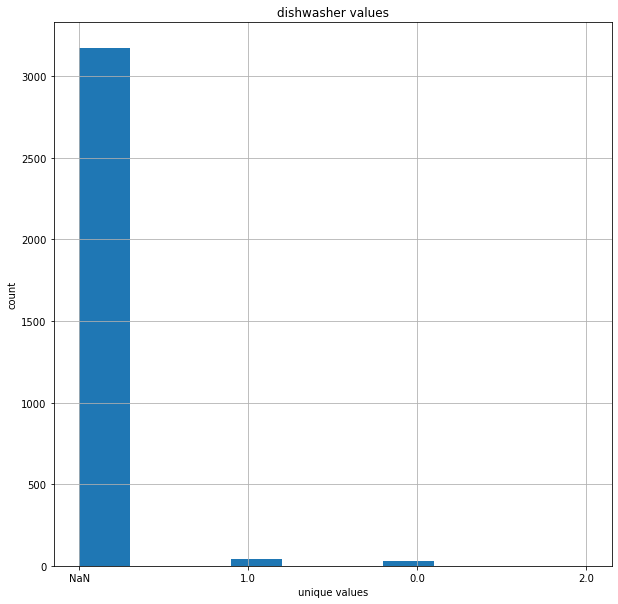

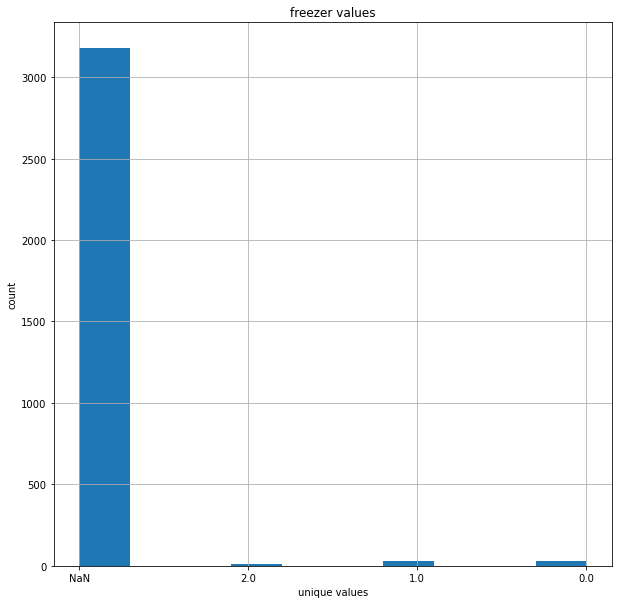

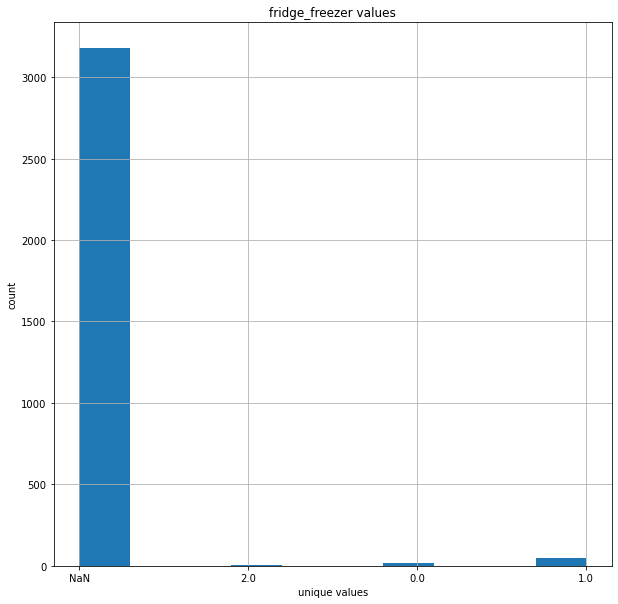

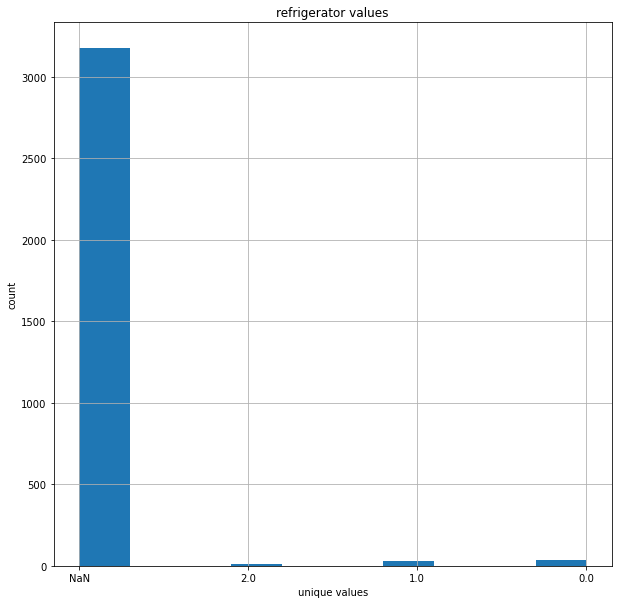

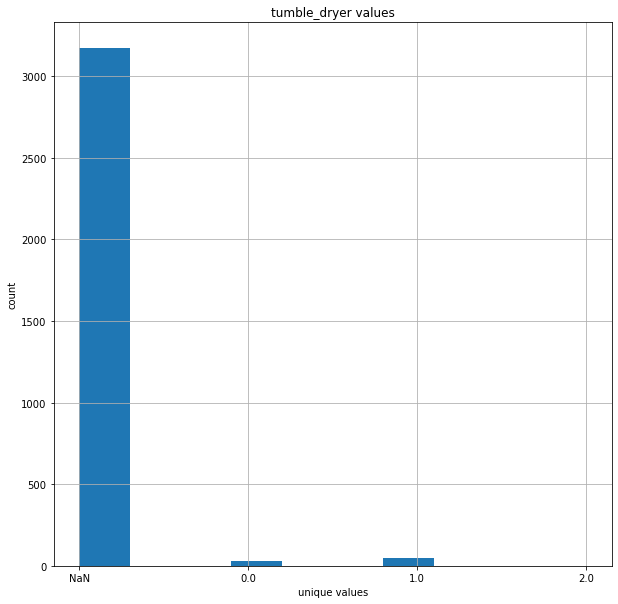

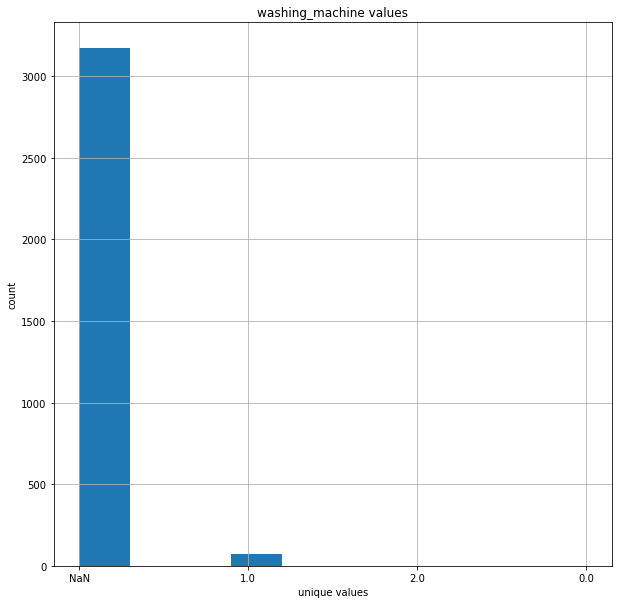

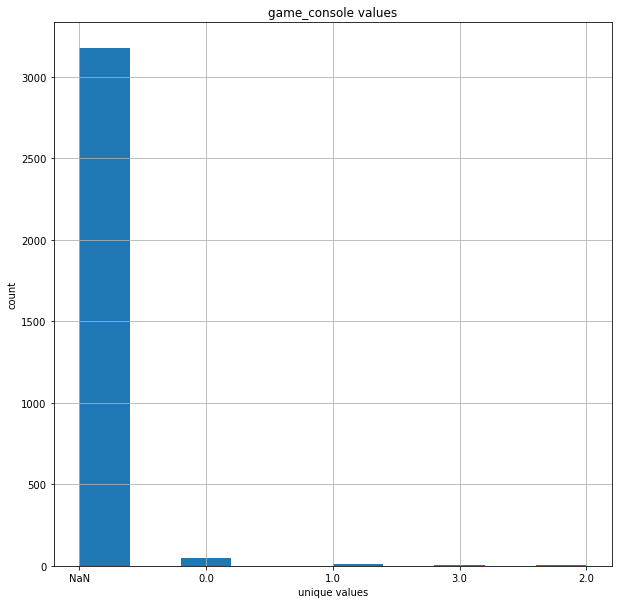

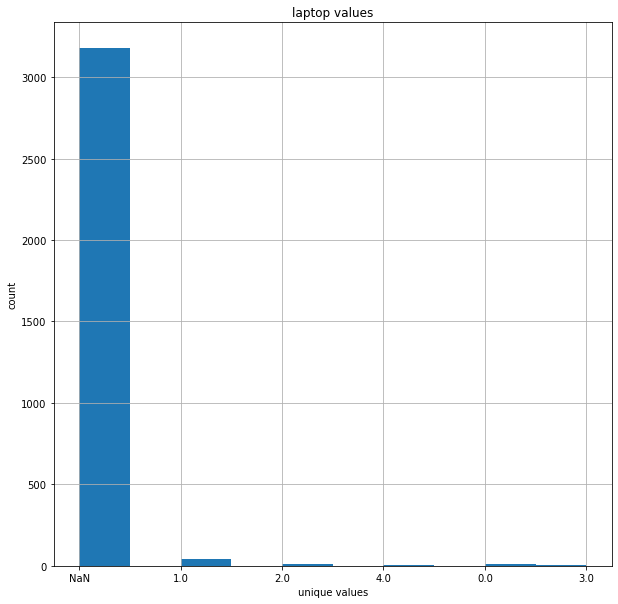

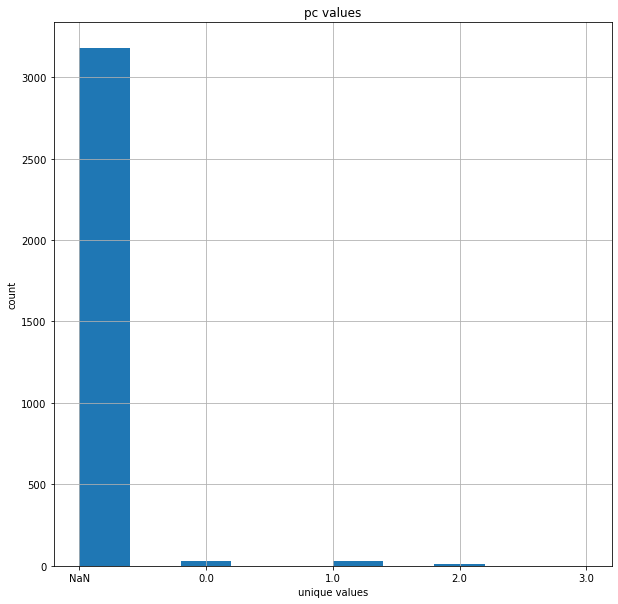

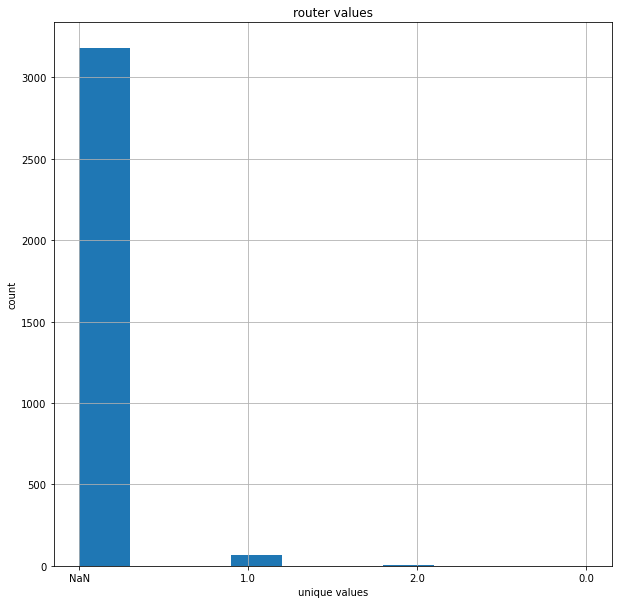

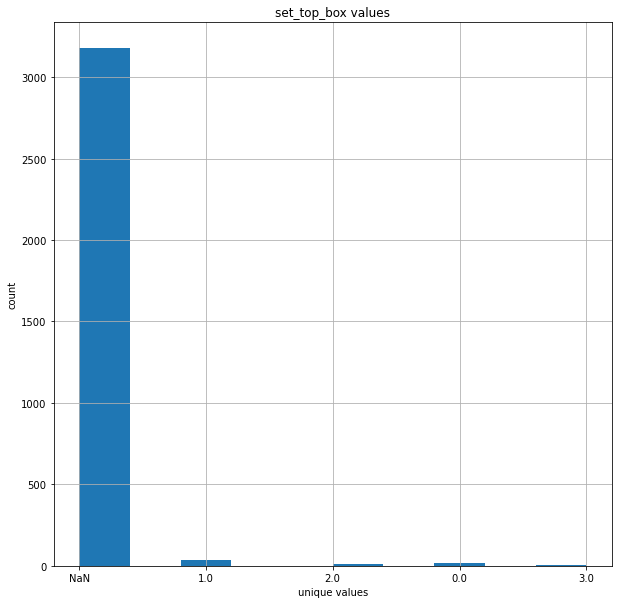

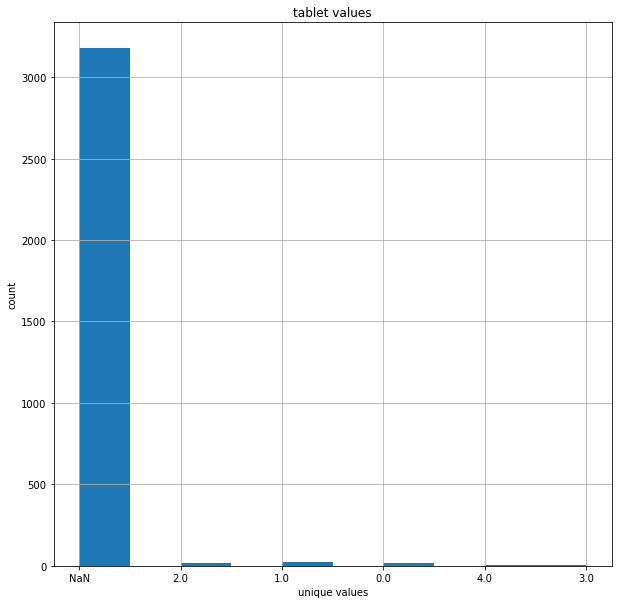

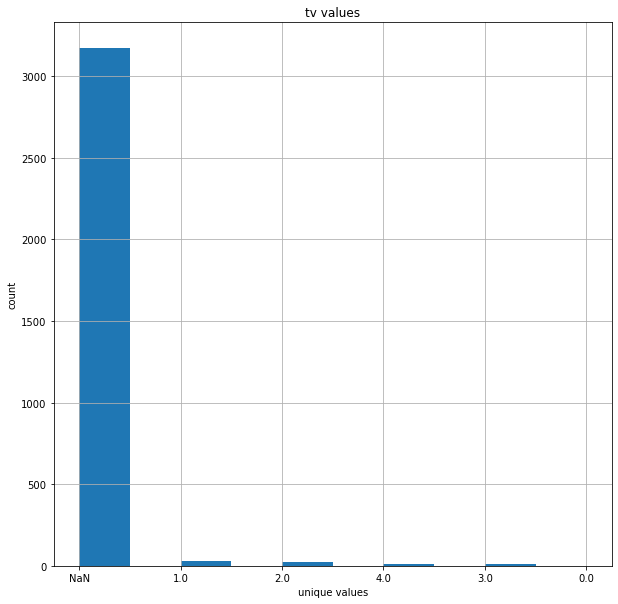

In [93]:
# plotting a histogram for each of the columns in the dataset
for column in df_info_all_meters.drop(["meter_id"],axis=1).columns:
    df_temp = df_info_all_meters[column].replace(np.nan,"NaN").apply(str)
    ax = df_temp.hist(figsize=(10,10))
    ax.set_xlabel("unique values")
    ax.set_ylabel("count")
    fig = ax.get_figure()
    plt.title(column+" values")
    plt.show(block=False)
    
    if(os.path.exists(f"../EDA/plots/addInfo/{column}_hist.png")==False):
        fig.savefig(f"../EDA/plots/addInfo/{column}_hist.png")
        
    plt.close(fig)

### Calculating percentage of missing values for each column

In [94]:
# Calculating percentage of missing values
#stores index of columns to keep: defaults all to true and will check which to make false
columns = np.full((df_info_all_meters.shape[1],), True, dtype=bool)

# getting the count of each object type in each column
for i in range(0,len(df_info_all_meters.columns)):
    column =df_info_all_meters.columns[i]
    #calculating the percentage of missing values
    percent_missing = df_info_all_meters[column].isnull().sum() * 100 / len(df_info_all_meters)
    print(column+" contains missing values: "+str(df_info_all_meters[column].isna().values.any()))
    print(column+" is missing: "+str(round(percent_missing,2))+"%")
    
    #if the percentage of missing values is greater than 50% mark them to be removed
    if(percent_missing>=50):
        print("Marked ",column,"for removal due to it having more than 50% missing values")
        columns[i] = False
    else:
        print("Not marked ",column,"for removal due to it not having more than 50% missing values")
    print()

meter_id contains missing values: False
meter_id is missing: 0.0%
Not marked  meter_id for removal due to it not having more than 50% missing values

dwelling_type contains missing values: True
dwelling_type is missing: 47.6%
Not marked  dwelling_type for removal due to it not having more than 50% missing values

num_occupants contains missing values: True
num_occupants is missing: 97.72%
Marked  num_occupants for removal due to it having more than 50% missing values

num_bedrooms contains missing values: True
num_bedrooms is missing: 42.76%
Not marked  num_bedrooms for removal due to it not having more than 50% missing values

heating_fuel contains missing values: True
heating_fuel is missing: 97.6%
Marked  heating_fuel for removal due to it having more than 50% missing values

hot_water_fuel contains missing values: True
hot_water_fuel is missing: 97.66%
Marked  hot_water_fuel for removal due to it having more than 50% missing values

boiler_age contains missing values: True
boiler_a

* As the histograms and calculations show: there is a massive amount of missing values
* Marked all columns with > 50% missing values for removal
    * as if more than half of the values are missing it is likely what we do impute won't be accurate
* Need to decide what to do with the the remaining 2 as they have 40% missing values: is this good enough?
    * Will likely require experimentation:
        * So will run one model which only uses energy
        * And one that uses addInfo after the missing values have been imputed

### Removing the columns with greater than 50% missing values

In [95]:
# Removing the columns marked for removal
selected_columns = df_info_all_meters.columns[columns]
df_info_all_meters = df_info_all_meters[selected_columns]

In [97]:
# inspecting the current state of df_info_all_meters
df_info_all_meters

,meter_id,dwelling_type,num_bedrooms
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,semi_detached_house,3.0
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,terraced_house,2.0
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,semi_detached_house,NaN
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,detached_house,4.0
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,NaN,NaN
...,...,...,...
3243,0xdf6a54b92985398af03423426e744c6d40ee8c69,NaN,NaN
3244,0x6b6ddc9a73405caab50c8d5575b72288aaa7e844,NaN,NaN
3245,0xd67e6b5f31d5286a2d4eec159b972e7f2197a67b,NaN,NaN
3246,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,NaN,NaN
